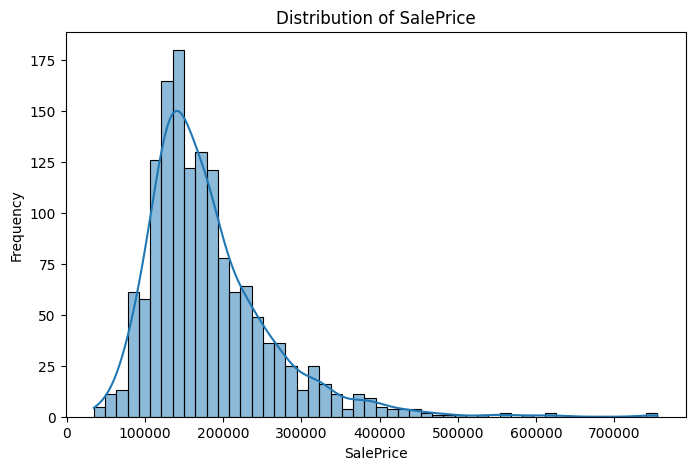

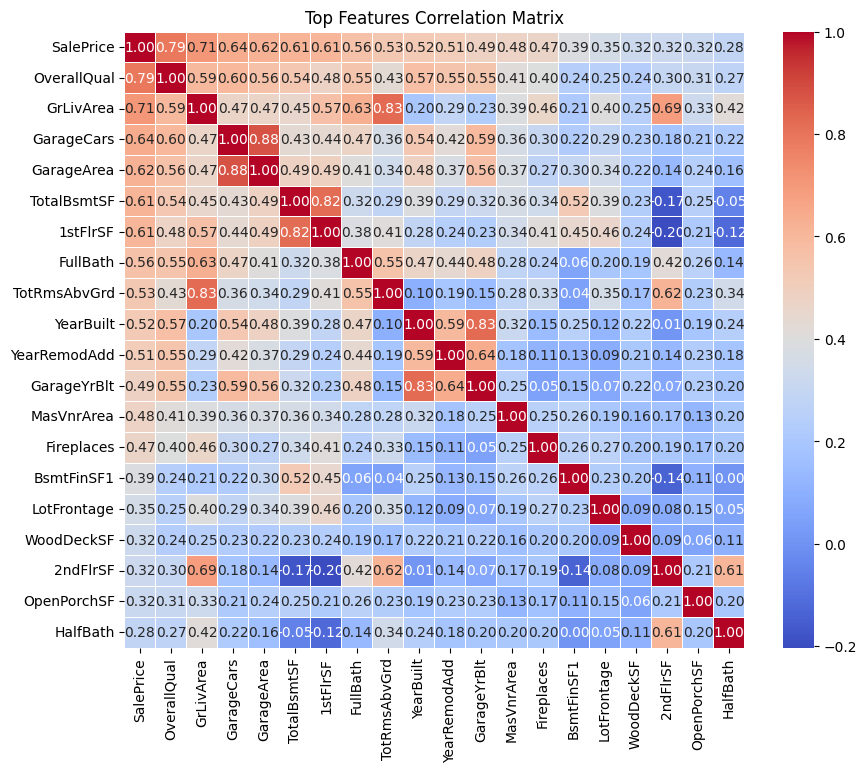

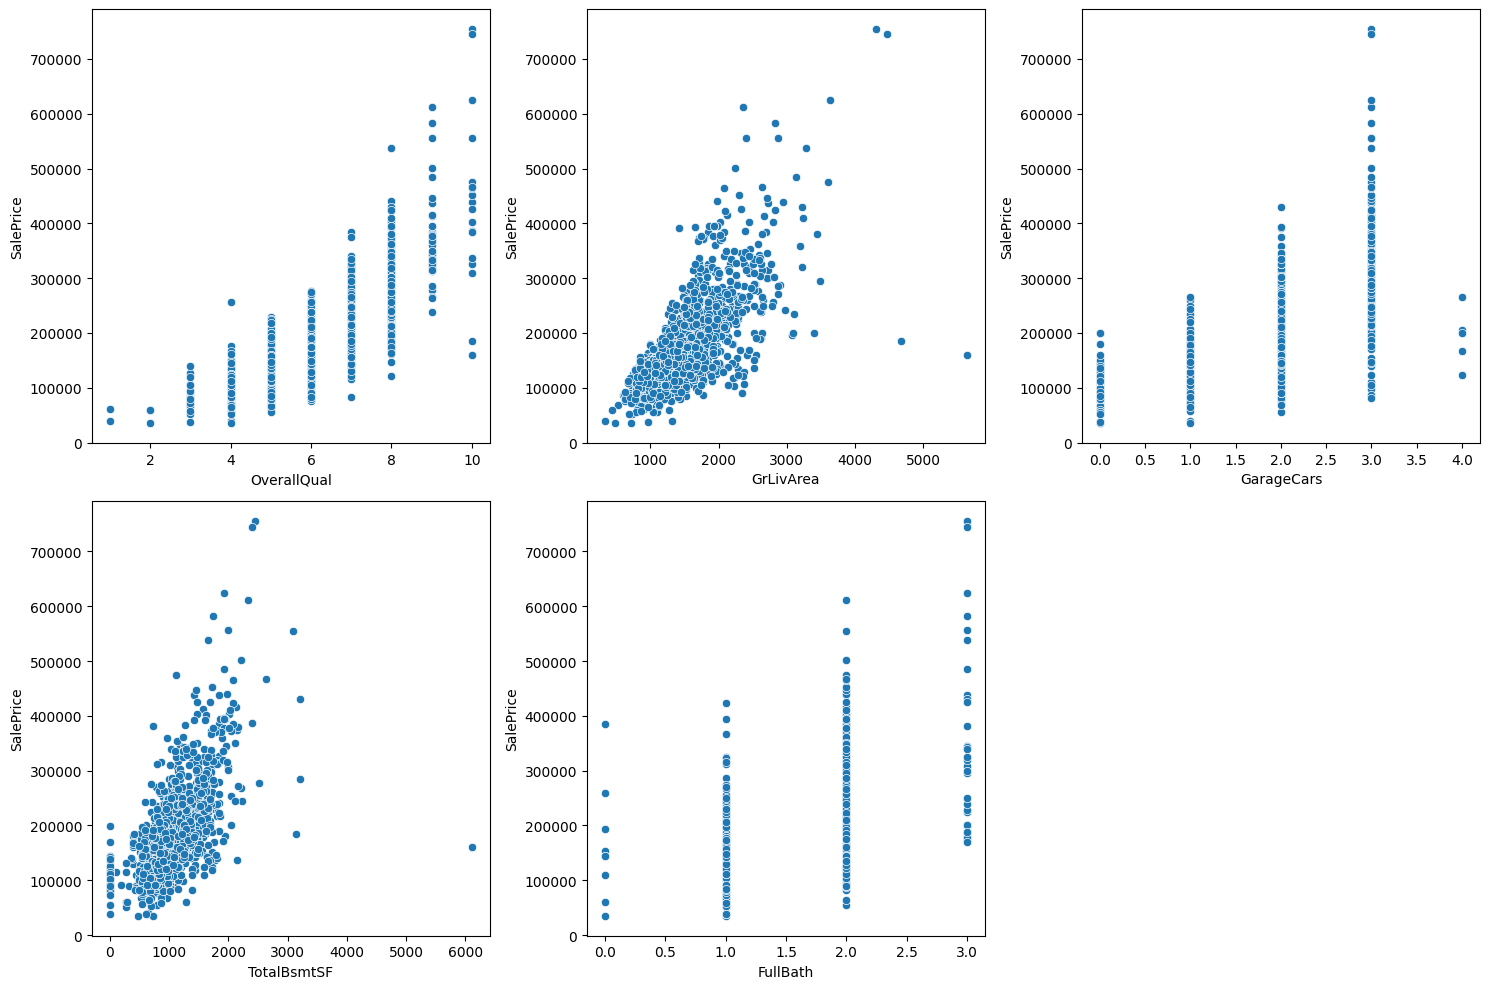

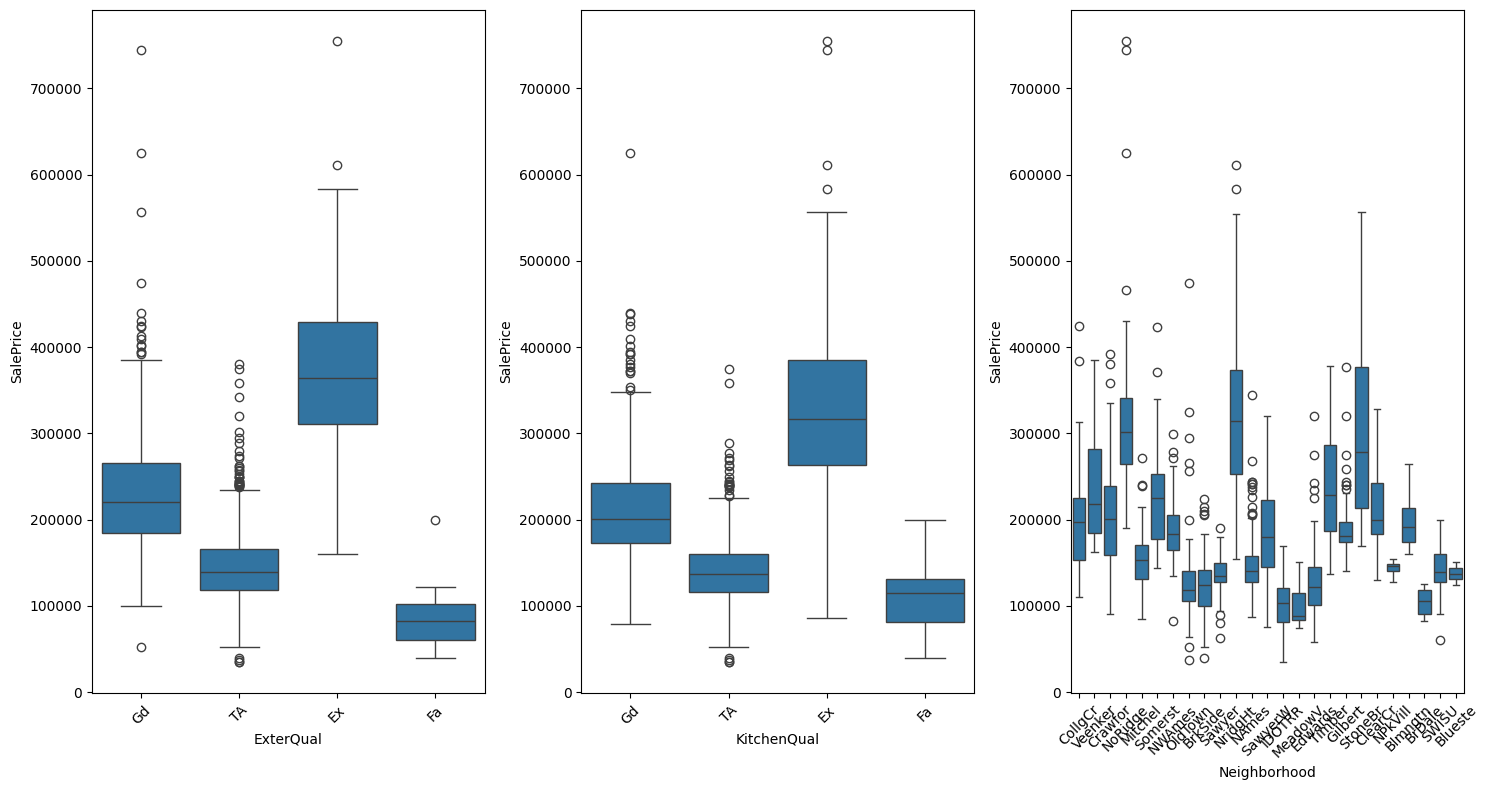

Fitting 3 folds for each of 243 candidates, totalling 729 fits

Model Performance (Validation Set):
                                     RMSE        R2
XGBoost (Tuned)              30633.524120  0.878923
Random Forest                31925.556011  0.868494
Lasso Regression             32247.831957  0.865826
Gradient Boosting Regressor  32384.976405  0.864682
Linear Regression            32795.873592  0.861226


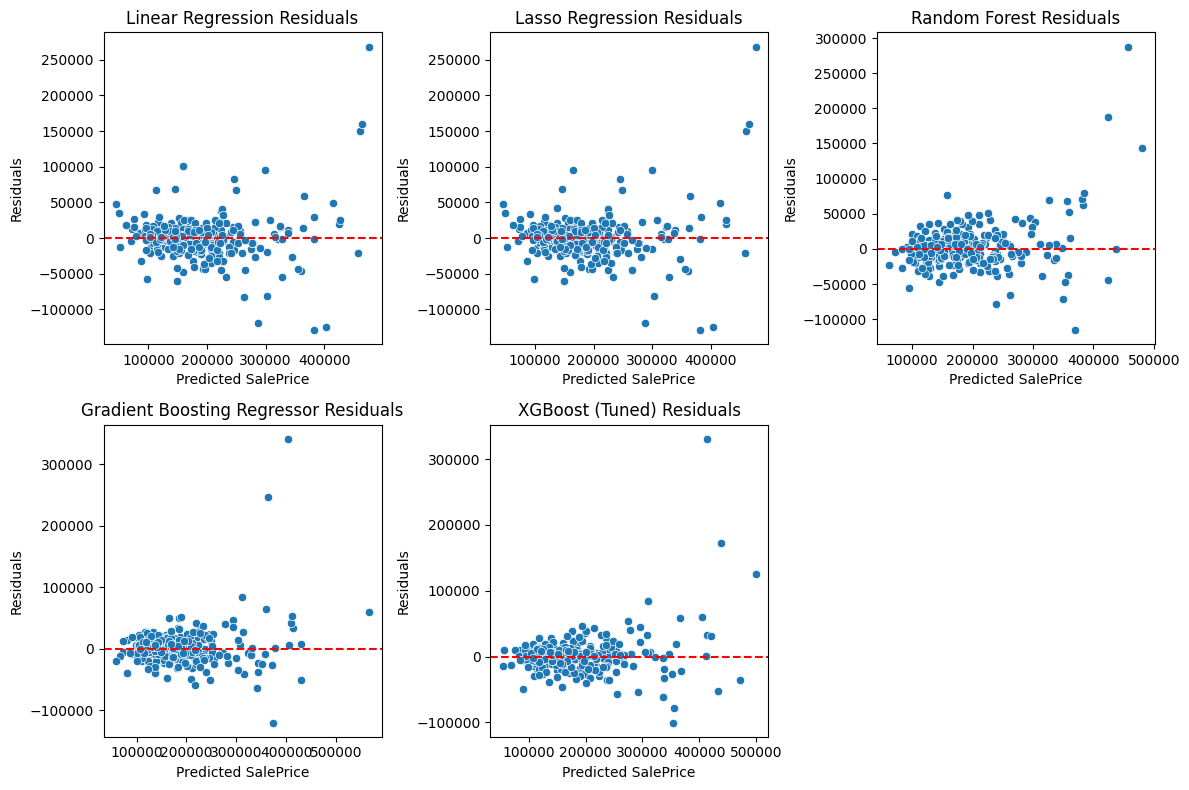

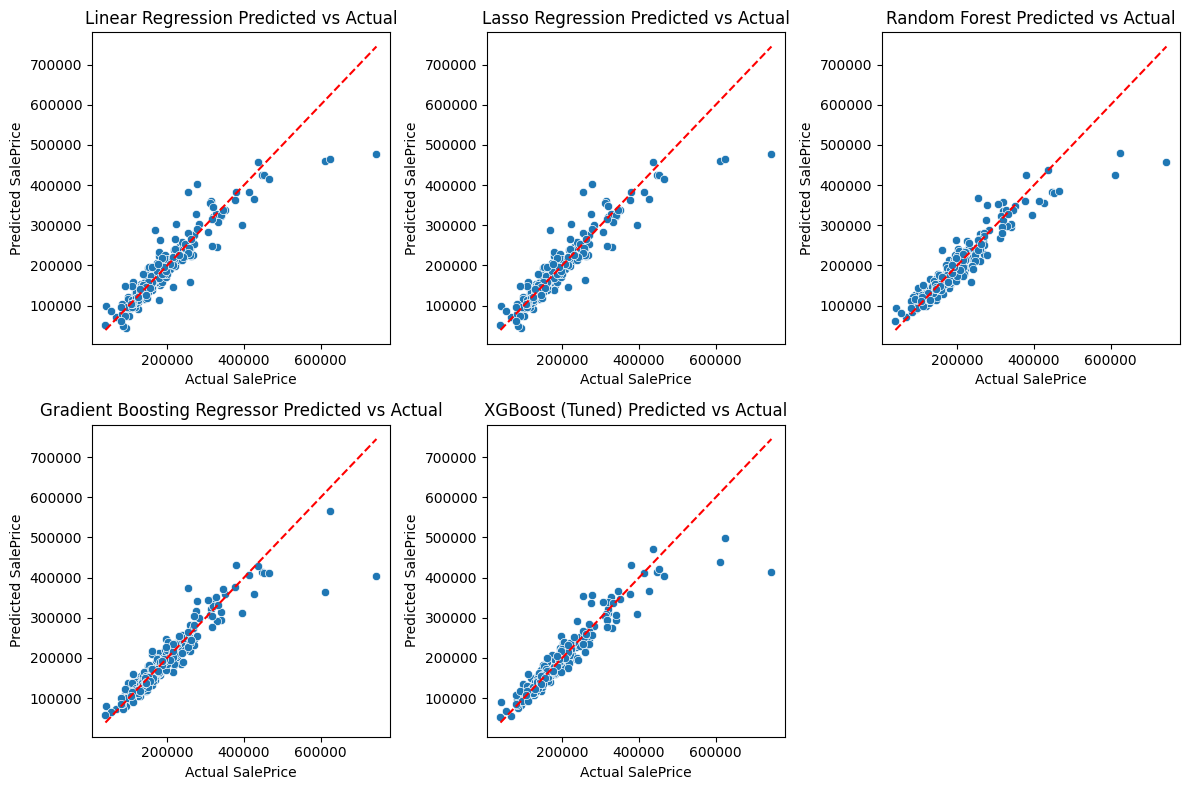

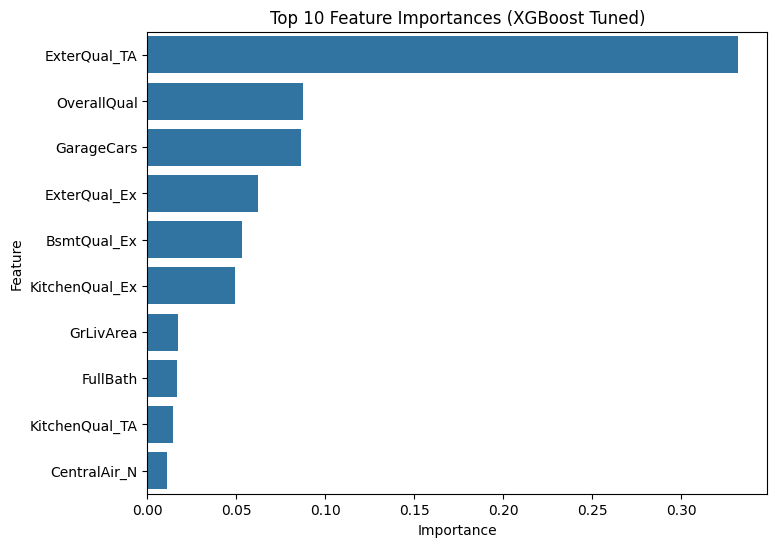

Original feature count: 303
Reduced feature count with PCA: 182


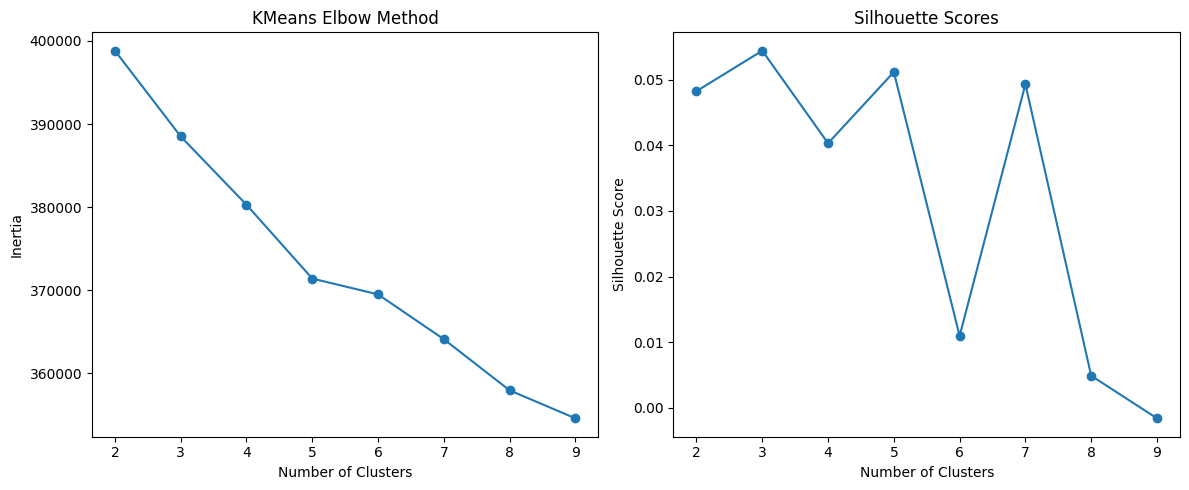

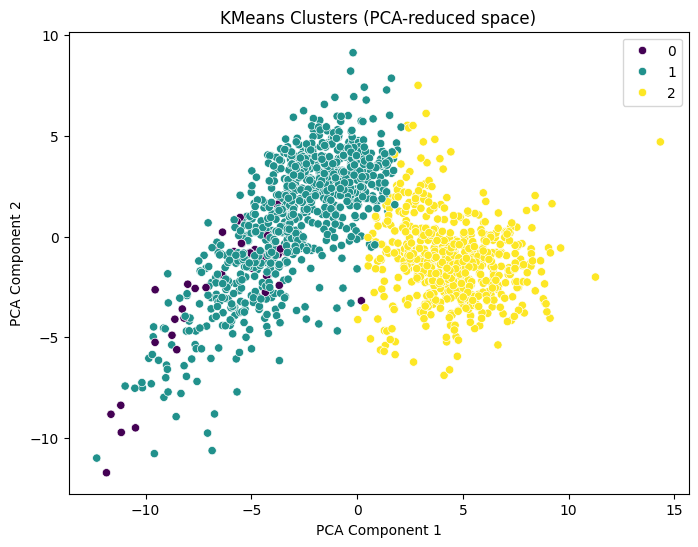

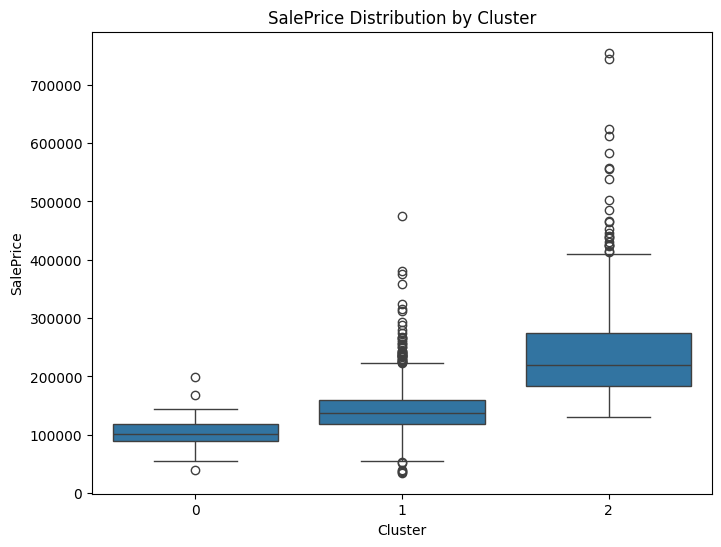

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Data collection
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Step 2: Data cleaning and processing
train_df.drop('Id', axis=1, inplace=True)
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

#Training dataset shape
#print("Training set shape:", train_df.shape)

# Test dataset shape
#print("Test set shape:", test_df.shape)

#List of all the columns
#print(train_df.columns.tolist())

#Info about data types and missing values
#train_df.info()

# Fill missing values
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
X[categorical_cols] = X[categorical_cols].fillna('None')

# One-hot encode categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cat = pd.DataFrame(encoder.fit_transform(X[categorical_cols]),
                           columns=encoder.get_feature_names_out(categorical_cols),
                           index=X.index)
X = X.drop(categorical_cols, axis=1).join(encoded_cat)

# Standardize numeric features
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=25)

# Step 3: Exploratory Data Analysis (EDA)
plt.figure(figsize=(8,5))
sns.histplot(train_df['SalePrice'], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

corr_matrix = train_df.corr(numeric_only=True)
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(20).index
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features],
            annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Top Features Correlation Matrix")
plt.show()

top_numeric_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
plt.figure(figsize=(15,10))
for i, feature in enumerate(top_numeric_features, 1):
    plt.subplot(2,3,i)
    sns.scatterplot(x=train_df[feature], y=train_df['SalePrice'])
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
plt.tight_layout()
plt.show()

categorical_features = ['ExterQual', 'KitchenQual', 'Neighborhood']
plt.figure(figsize=(15,8))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1,3,i)
    sns.boxplot(x=train_df[feature], y=train_df['SalePrice'])
    plt.xticks(rotation=45)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
plt.tight_layout()
plt.show()

# Step 4: Model Selection and Training
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.001, max_iter=10000, tol=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=25),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=25)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    results[name] = {"RMSE": np.sqrt(mean_squared_error(y_val, y_pred)),
                     "R2": r2_score(y_val, y_pred)}

# Tuning the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=25)
param_grid_xgb = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
xgb_cv = GridSearchCV(xgb, param_grid_xgb, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
xgb_cv.fit(X_train, y_train)
best_xgb = xgb_cv.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
results["XGBoost (Tuned)"] = {"RMSE": np.sqrt(mean_squared_error(y_val, y_pred_xgb)),
                              "R2": r2_score(y_val, y_pred_xgb)}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T.sort_values("RMSE")
print("\nModel Performance (Validation Set):")
print(results_df)

# Step 5: Model Evaluation
plt.figure(figsize=(12,8))
for i, (name, model) in enumerate(list(models.items()) + [("XGBoost (Tuned)", best_xgb)], 1):
    y_pred = model.predict(X_val)
    residuals = y_val - y_pred
    plt.subplot(2,3,i)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted SalePrice")
    plt.ylabel("Residuals")
    plt.title(f"{name} Residuals")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
for i, (name, model) in enumerate(list(models.items()) + [("XGBoost (Tuned)", best_xgb)], 1):
    y_pred = model.predict(X_val)
    plt.subplot(2,3,i)
    sns.scatterplot(x=y_val, y=y_pred)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title(f"{name} Predicted vs Actual")
plt.tight_layout()
plt.show()

# Step 6: Feature importance using the best performing module - XGBoost Tuned
winner = best_xgb  
importances = winner.feature_importances_
indices = np.argsort(importances)[::-1][:10] 
features = X_train.columns[indices]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=features)
plt.title("Top 10 Feature Importances (XGBoost Tuned)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95, random_state=25)  
X_pca = pca.fit_transform(X)

print(f"Original feature count: {X.shape[1]}")
print(f"Reduced feature count with PCA: {X_pca.shape[1]}")

# Apply KMeans clustering
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=25, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Plot inertia (Elbow method) and Silhouette Score
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.title("KMeans Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Choose optimal clusters (k=3 based on baseline assumption)
kmeans = KMeans(n_clusters=3, random_state=25, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels back to original dataset
train_df['Cluster'] = clusters

# Visualize clusters using first two PCA components
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="viridis")
plt.title("KMeans Clusters (PCA-reduced space)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Compare SalePrice distribution across clusters
plt.figure(figsize=(8,6))
sns.boxplot(x="Cluster", y="SalePrice", data=train_df)
plt.title("SalePrice Distribution by Cluster")
plt.show()

